In [3]:
setwd("/projects/CARDIPS/analysis/epigenome_resource")
source("analyses/jennifer/notebooks/functions.R")

set.seed(5366)

# Figure 6: Plot QTL and GWAS Associations at the TBX20 Locus

## read supplemental table for GWAS colocalizations

In [9]:
gwas_coloc = fread("manuscript/tables/Table_SX_GWAS_Colocalizations.txt", data.table = F) %>% filter(Colocalized == T)
head(gwas_coloc,3)

,Tissue,Trait_Description,Trait_ID,Cluster_ID,QTL_Combination,Membership,Element_ID,Condition,Element_Cond,Element_Name,⋯,Beta.GWAS,SE.GWAS,Pvalue.GWAS,99Credible_Set_Size,Colocalized,Has_TFBS,GWAS_Index,GWAS_QTL_Combination_Collapse,Fetal_Unique_QTL,Fetal_Unique_GWAS_Locus
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<int>,<lgl>,<lgl>,<chr>,<chr>,<lgl>,<chr>
1,CVPC,Aging,timmers2020_healthspan_lifespan_longevity,CVPC_10833,eQTL,Singleton,ENSG00000182511.12,1,ENSG00000182511.12_1,FES,⋯,-0.009921,0.001680,3.52501e-09,5,TRUE,FALSE,15_90885406,caQTL-haQTL-eQTL,TRUE,FALSE
2,CVPC,Aging,timmers2020_healthspan_lifespan_longevity,CVPC_10854,haQTL,Singleton,cvpc_chip_peak_21796,0,cvpc_chip_peak_21796_0,cvpc_chip_peak_21796,⋯,-0.009921,0.001680,3.52501e-09,8,TRUE,FALSE,15_90885406,caQTL-haQTL-eQTL,FALSE,FALSE
3,CVPC,Aging,timmers2020_healthspan_lifespan_longevity,CVPC_11914,caQTL,Singleton,cvpc_atac_peak_101289,0,cvpc_atac_peak_101289_0,cvpc_atac_peak_101289,⋯,0.012461,0.001815,6.58645e-12,3,TRUE,FALSE,16_89959744,caQTL,FALSE,FALSE


## read supplemental table for GWAS manifest

In [10]:
manifest = fread("manuscript/tables/Table_SX_GWAS_Manifest.txt", data.table = F)
head(manifest,3)

,Trait_Description,Trait_ID,Download_Source,Publication
,<chr>,<chr>,<chr>,<chr>
1,Aging,timmers2020_healthspan_lifespan_longevity,https://doi.org/10.7488/ds/2793,"Timmers et al., Nature Communications, 2020 (PMID: 32678081)"
2,Angina Pectoris,icd10-I20-both_sexes.meta,https://pan.ukbb.broadinstitute.org/,Pan-UK Biobank
3,Atrial Fibrillation,icd10-I48-both_sexes.meta,https://pan.ukbb.broadinstitute.org/,Pan-UK Biobank


## read gene info

    generated using Gencode GTF file

In [11]:
geneinfo = fread("/reference/private/Gencode.v44lift38/gene_info.txt")
head(geneinfo,3)

chrom,start,end,strand,gene_id,gene_name,gene_type,havana_gene
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
chr1,11869,14409,+,ENSG00000290825.1,DDX11L2,lncRNA,
chr1,12010,13670,+,ENSG00000223972.6,DDX11L1,transcribed_unprocessed_pseudogene,OTTHUMG00000000961.2
chr1,14404,29570,-,ENSG00000227232.5,WASH7P,unprocessed_pseudogene,OTTHUMG00000000958.1


## read supplemental table for QTL module information

In [27]:
mods = fread("/frazer01/home/tarthur/projects/Resource/SupplementalTables/TableS11_QTLModules.txt", data.table = F) 
colnames(mods) = gsub(" ", "_", colnames(mods))
mods = mods %>%mutate(Element_Cond = paste(Element_ID, Condition, sep = "_"))
head(mods,3)

,Tissue,Cluster_ID,Element_ID,Condition,Molecular_QTL_Type,Membership,No._Colocalizations,No._QTLs_in_Module,Element_Cond
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<int>,<chr>
1,iPSC,iPSC_1,ipsc_atac_peak_17280,0,caQTL,Module,8,10,ipsc_atac_peak_17280_0
2,iPSC,iPSC_1,ipsc_atac_peak_17286,0,caQTL,Module,9,10,ipsc_atac_peak_17286_0
3,iPSC,iPSC_1,ipsc_atac_peak_17287,0,caQTL,Module,9,10,ipsc_atac_peak_17287_0


## we are interested in the birth weight association at the TBX20 locus

In [28]:
gwas_coloc %>% filter(Element_Name == "TBX20")

Tissue,Trait_Description,Trait_ID,Cluster_ID,QTL_Combination,Membership,Element_ID,Condition,Element_Cond,Element_Name,⋯,Beta.GWAS,SE.GWAS,Pvalue.GWAS,99Credible_Set_Size,Colocalized,Has_TFBS,GWAS_Index,GWAS_QTL_Combination_Collapse,Fetal_Unique_QTL,Fetal_Unique_GWAS_Locus
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<int>,<lgl>,<lgl>,<chr>,<chr>,<lgl>,<chr>
CVPC,Birth Weight,BW3_EUR_summary_stats,CVPC_49,caQTL-eQTL,Module,ENSG00000164532.11,0,ENSG00000164532.11_0,TBX20,⋯,-0.0219,0.0038,1e-08,79,TRUE,FALSE,7_35256265,caQTL-eQTL,FALSE,FALSE


## set variables

In [29]:
chr      = 7
tissue   = "CVPC"
qtl4gwas = "ENSG00000164532.11_0" # any element_cond in the cluster, typically the one that colocalized with the GWAS signal (see above cell)


## extract info for plotting

In [44]:
# get cluster ID
cluster = unique(mods[mods$Element_Cond == qtl4gwas,]$Cluster_ID)
message(paste("Cluster ID:", cluster), appendLF = F)

# get element IDs in cluster
elements = mods[mods$Cluster_ID == cluster,]$Element_Cond
message(paste("Elements in cluster:", paste(elements, collapse = ", ")), appendLF = F)

# get all traits associated with the cluster
traits = gwas_coloc[gwas_coloc$Cluster_ID == cluster,]$Trait_ID

# get lead candidate causal SNP
topsnp = gwas_coloc %>% 
    filter(Cluster_ID == cluster) %>% 
    dplyr::select(Element_ID, Trait_Description ,Top_SNP_ID, Top_SNP_PP) %>% 
    dplyr::arrange(desc(Top_SNP_PP)) %>% 
    head(1) %>% pull(Top_SNP_ID)

message(paste("Top SNP ID:", topsnp), appendLF = F)

# extract SNP position
topsnp_pos = as.numeric(unlist(strsplit(topsnp, "_"))[3])
message(paste("Top SNP position:", topsnp_pos), appendLF = F)

Cluster ID: CVPC_49
Elements in cluster: ENSG00000289089.1_0, ENSG00000288947.2_0, ENSG00000164532.11_0, ENSG00000289335.1_0, ENSG00000226063.1_0, cvpc_atac_peak_233871_0
Top SNP ID: VAR_7_35255754_A_G
Top SNP position: 35255754


## get QTL p-value associations

In [45]:
qtldata = as.data.frame(rbindlist(lapply(elements, function(id)
{
    element_id = substr(id, 1, nchar(id) -  2)
    qtl_type = substr(id, nchar(id), nchar(id))
    analysis = ifelse(id %like% "ENSG", "eqtls", ifelse(id %like% "atac", "caqtls", "haqtls"))
    qtl_file = paste(analysis, tissue, "step_4/qtl_by_element/qtl", paste("qtl", element_id, "txt", sep = "."), sep = "/")
    message(paste("Reading file:", qtl_file), appendLF = F)
    if (file.exists(qtl_file))
    {
        fread(qtl_file, data.table = F) %>% filter(type == qtl_type) 
    }
}))) %>% dplyr::select(chrom, pos, pval, element_id) %>% mutate(thresh = 5e-05)  %>% mutate(chrom = gsub("chr", "", chrom))

head(qtldata,5)

Reading file: eqtls/CVPC/step_4/qtl_by_element/qtl/qtl.ENSG00000289089.1.txt
Reading file: eqtls/CVPC/step_4/qtl_by_element/qtl/qtl.ENSG00000288947.2.txt
Reading file: eqtls/CVPC/step_4/qtl_by_element/qtl/qtl.ENSG00000164532.11.txt
Reading file: eqtls/CVPC/step_4/qtl_by_element/qtl/qtl.ENSG00000289335.1.txt
Reading file: eqtls/CVPC/step_4/qtl_by_element/qtl/qtl.ENSG00000226063.1.txt
Reading file: caqtls/CVPC/step_4/qtl_by_element/qtl/qtl.cvpc_atac_peak_233871.txt


,chrom,pos,pval,element_id,thresh
,<chr>,<int>,<dbl>,<chr>,<dbl>
1,7,34197904,0.1981326,ENSG00000289089.1,5e-05
2,7,34199076,0.8283383,ENSG00000289089.1,5e-05
3,7,34199411,0.1981326,ENSG00000289089.1,5e-05
4,7,34199667,0.1981326,ENSG00000289089.1,5e-05
5,7,34199767,0.1981326,ENSG00000289089.1,5e-05


## get GWAS p-value associations

### open GWAS colocalization results

In [46]:
qtl_type = substr(qtl4gwas, nchar(qtl4gwas), nchar(qtl4gwas))
element_id = substr(qtl4gwas, 1, nchar(qtl4gwas) - 2)
analysis = ifelse(qtl4gwas %like% "ENSG", "eqtls", ifelse(qtl4gwas %like% "atac", "caqtls", "haqtls"))
gwas_file = paste("analyses/jennifer/gwas_coloc", analysis, tissue, paste(paste(qtl_type, element_id, sep = "-"), "robj", sep = "."), sep = "/")
message(paste("Reading:", gwas_file), appendLF = F)

load(gwas_file, verbose = T) # outputs a list of coloc results (summary, results, priors, input) for to each trait

Reading: analyses/jennifer/gwas_coloc/eqtls/CVPC/0-ENSG00000164532.11.robj


Loading objects:
  outlist


In [49]:
names(outlist[[1]])

[1] "summary" "results" "priors"  "input"

In [52]:
head(outlist[[1]]$input,2) # input data for colocalization (x = QTL, y = GWAS)

,id,a1.x,a2.x,beta.x,se.x,maf.x,p.x,bonferroni,tests,a1.y,a2.y,beta.y,se.y,p.y,n,maf.y
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
1,VAR_7_34206257_G_A,G,A,0.1594753,0.1446743,0.0695971,0.2695091,1,2370,G,A,0.003136,0.005669,0.5800962,400963,0.04843
2,VAR_7_34206312_G_A,G,A,0.1594753,0.1446743,0.0695971,0.2695091,1,2370,G,A,0.003470,0.005664,0.5401321,400963,0.04851


### extract GWAS p-values for each trait that colocalized with the QTL module / singleton

In [34]:
message(paste("Getting data for the following traits:", paste(unique(traits), collapse = "\n")), appendLF = F)

gwasdata = as.data.frame(rbindlist(lapply(unique(traits), function(trait)
{
    out = outlist[[trait]]$input %>% 
        mutate(pos = unlist(lapply(id, function(x) { as.numeric(unlist(strsplit(x, "_"))[3]) }))) %>% 
        mutate(chrom = unlist(lapply(id, function(x) { as.numeric(unlist(strsplit(x, "_"))[2] )}))) %>%
        select(chrom, pos, p.y) %>% 
        mutate(element_id = manifest[manifest$Trait_ID == trait,]$Trait_Description) %>% dplyr::rename(pval = p.y)
    if (nrow(out) > 0)
    {
        return(out)
    }
}))) %>% mutate(thresh = 5e-08)

Getting data for the following traits: BW3_EUR_summary_stats


## concatenate QTL and GWAS associations

In [ ]:
qtldata = rbind(qtldata, gwasdata)

## annotate which association is for eQTL, caQTL, haQTL, or GWAS

In [35]:
qtldata$type = ifelse(qtldata$element_id %like% "ENSG", "eqtl",
                       ifelse(qtldata$element_id %like% "atac", "caqtl",
                              ifelse(qtldata$element_id %like% "chip", "haqtl", "gwas")))

## re-name genes

In [38]:
unique(qtldata$element_id)

[1] "ENSG00000289089.1"     "ENSG00000288947.2"     "ENSG00000164532.11"   
[4] "ENSG00000289335.1"     "ENSG00000226063.1"     "cvpc_atac_peak_233871"
[7] "Birth Weight"

In [39]:
change_names = list("ENSG00000164532.11" = "TBX20") # names you want to change in plot

for (name in names(change_names))
{
    qtldata[qtldata$element_id == name,]$element_id = change_names[[name]]
}

## set order to what to plot first

In [40]:
order = c("Birth Weight", 
          "QRS duration", 
          "cvpc_atac_peak_233871",  
          "TBX20", 
          "ENSG00000289089.1", 
          "ENSG00000288947.2", 
          "ENSG00000289335.1", 
          "ENSG00000226063.1") # order you want them to be plotted (with updated names)

In [41]:
qtldata$element_id = factor(qtldata$element_id, levels = order)

In [42]:
unique(qtldata$element_id)

[1] ENSG00000289089.1     ENSG00000288947.2     TBX20                
[4] ENSG00000289335.1     ENSG00000226063.1     cvpc_atac_peak_233871
[7] Birth Weight         
8 Levels: Birth Weight QRS duration cvpc_atac_peak_233871 ... ENSG00000226063.1

## run PLINK to get LD with lead SNP

In [43]:
# first write all snps to test for LD
qtldata$id = paste(qtldata$chrom, qtldata$pos, sep = "_")
writeLines(unique(qtldata$id), "analyses/jennifer/scratch/snps.txt", sep = "\n")

# run LD plink
reference = paste("analyses/jennifer/gwas_independent/reference", paste0("chr", chr), sep = "/")
out = "analyses/jennifer/scratch/plink"
cmd = paste("plink --extract", "analyses/jennifer/scratch/snps.txt", "--bfile", reference, "--r2", "square", "--out", out, "--make-bed")

message(cmd)
system(cmd)

# read bim file, which contains the list of snps (needed to add rownames and colnames to ld file)
bim = fread("analyses/jennifer/scratch/plink.bim", data.table = F, header = F) %>% mutate(id = paste(V2, V5, V6, sep = "_")) 

# read ld file
ld = fread("analyses/jennifer/scratch/plink.ld", data.table = F)
rownames(ld) = bim$id
colnames(ld) = bim$id

# add rownames and colnames
bim = bim %>% filter(duplicated(V2) == F)

ld = ld[bim$id, bim$id]
colnames(ld) = bim$V2
rownames(ld) = bim$V2

# melt
ld = melt(as.matrix(ld)) %>% dplyr::rename(LD = value) %>% filter(Var1 == paste(unlist(strsplit(topsnp, "_"))[2:3], collapse = "_"))

head(ld,4)

plink --extract analyses/jennifer/scratch/snps.txt --bfile analyses/jennifer/gwas_independent/reference/chr7 --r2 square --out analyses/jennifer/scratch/plink --make-bed

Warning message in melt(as.matrix(ld)):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(as.matrix(ld)). In the next version, this warning will become an error.”


,Var1,Var2,LD
,<fct>,<fct>,<dbl>
1,7_35255754,7_34197904,0.00190900
2,7_35255754,7_34199076,0.00166153
3,7_35255754,7_34199411,0.00112403
4,7_35255754,7_34199667,0.00112403


## annotate variants with LD and colors

In [128]:
# add LD column
qtldata2 = merge(qtldata, ld %>% dplyr::rename(id = Var2) %>% select(id, LD), by = "id") %>% filter(!is.na(LD))
qtldata2$LD_group = ifelse(qtldata2$LD <= 0.2, "<0.2", NA)
qtldata2$LD_group = ifelse(qtldata2$LD > 0.2 & qtldata2$LD <= 0.4, "0.2-0.4", qtldata2$LD_group)
qtldata2$LD_group = ifelse(qtldata2$LD > 0.4 & qtldata2$LD <= 0.6, "0.4-0.6", qtldata2$LD_group)
qtldata2$LD_group = ifelse(qtldata2$LD > 0.6 & qtldata2$LD <= 0.8, "0.6-0.8", qtldata2$LD_group)
qtldata2$LD_group = ifelse(qtldata2$LD > 0.8, ">0.8", qtldata2$LD_group)

groups = c("<0.2", "0.2-0.4", "0.4-0.6", "0.6-0.8", ">0.8")

color_gradients = list("eqtl" = c("#ecede9", "#ffb344", "#e18c5a", "#8f5137", "#5c4033"), # orange-brown
                       "haqtl" = c("#ecede9", "#9689b9", "#61679a", "#534876", "#2d2c4e"), # purple
                       "caqtl" = c("#ecede9", "#93c47d", "#6aa84f", "#4c7835", "#274e13"), # green
                       "gwas" = c("darkblue", "#94cdd5", "green", "orange", "red"))


qtldata3 = as.data.frame(rbindlist(lapply(unique(qtldata2$type), function(t)
{
    this = qtldata2 %>% filter(type == t)
    this$color = suppressWarnings(mapvalues(this$LD_group, from = groups, to = color_gradients[[t]]))
    return(this)
})))



## write source data

In [129]:
fwrite(qtldata3, "manuscript/figures/SourceData.Figure6.TBX20_Manhattan.txt", row.names = F, sep = "\t")

## plot

Warning message:
“Removed 15177 rows containing missing values (`geom_point()`).”


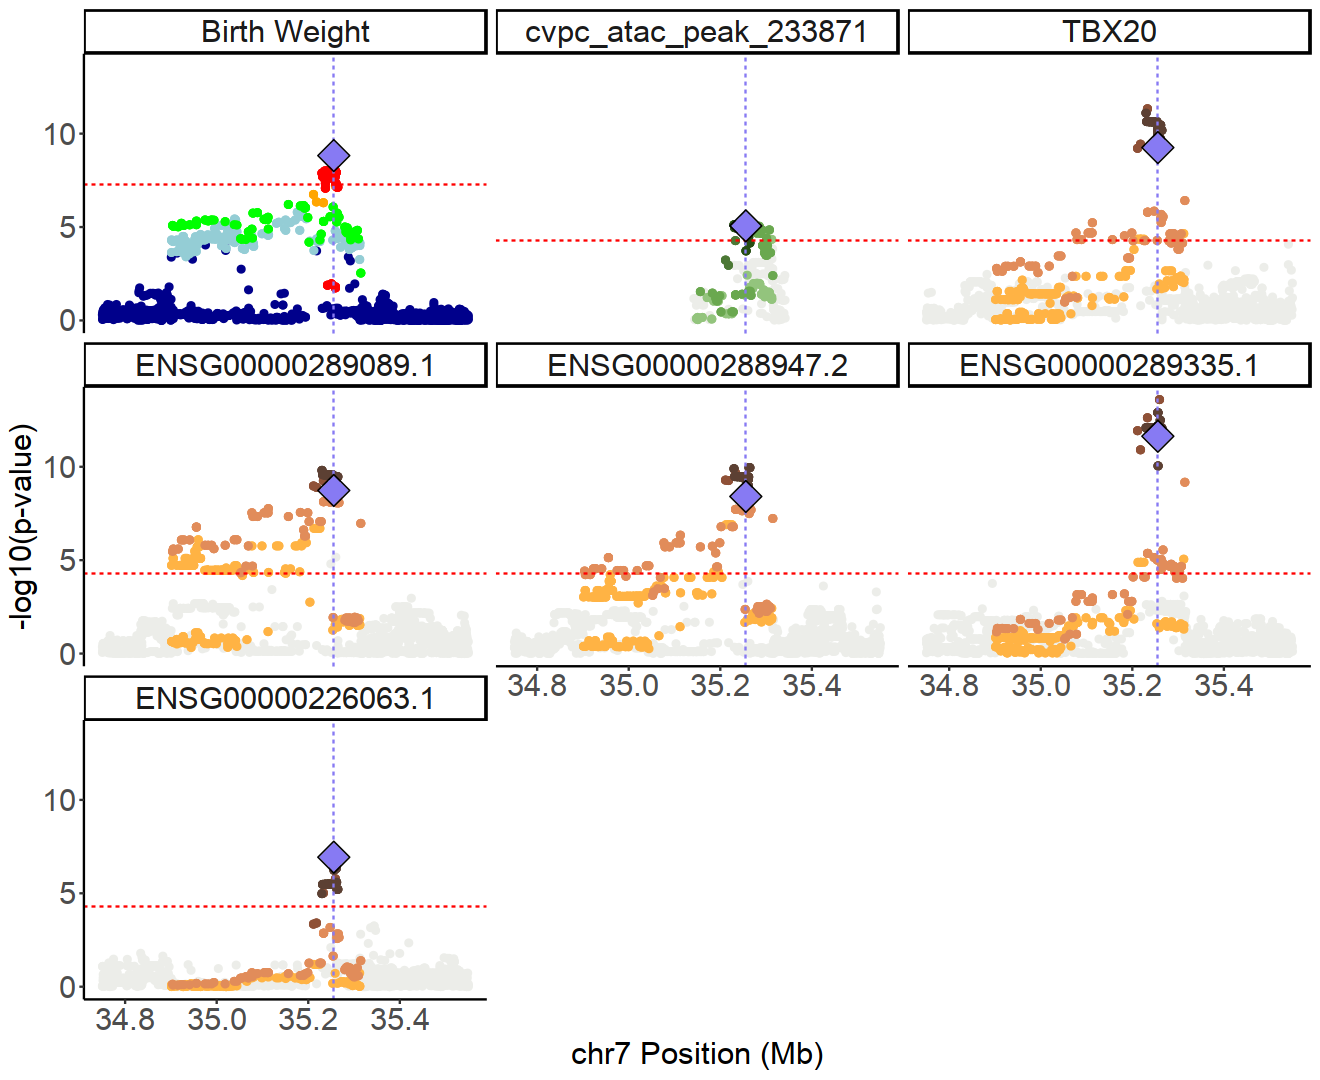

In [130]:
psize(w = 11, h = 9)
ggplot(qtldata3, aes(x = pos/1e6, y = -log10(pval), color = color)) + geom_point() + jn_classic + 
    facet_wrap(.~element_id, ncol = 3) +
    theme(strip.text = element_text(size= 18)) + xlab("chr7 Position (Mb)") + ylab("-log10(p-value)") + 
    geom_point(data = qtldata3 %>% filter(LD >= 0.2)) + 
    geom_point(data = qtldata3 %>% filter(LD >= 0.4)) + 
    geom_point(data = qtldata3 %>% filter(LD >= 0.8)) +
    scale_color_identity()  +
    geom_vline(xintercept = topsnp_pos/1e6, linetype = "dashed", color = "#877af3")  + 
    geom_hline(data = qtldata3, aes(yintercept = -log10(thresh)), linetype = "dashed", color = "red") + 
    geom_point(data = qtldata3 %>% filter(pos == topsnp_pos), color = "#877af3", size = 8, shape = 18) + 
    geom_point(data = qtldata3 %>% filter(pos == topsnp_pos), color = "black", size = 6, shape = 5) +
    xlim(34.75, 35.55)

## plot LD Legends

In [131]:
library(grid)

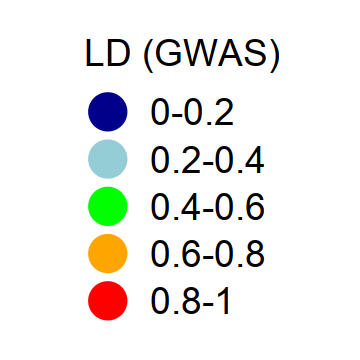

In [132]:
a = qtldata3 %>%
    filter(element_id %like% "Birth") %>%
    mutate(LD_group = factor(LD_group, levels = groups))

legend0 = ggplot(a, aes(x = pos/1e6, y = -log10(pval), color = LD_group)) + geom_point() + jn_classic  +
    facet_wrap(.~element_id, ncol = 3)  + 
    theme(
        legend.text = element_text(size = 22),
        legend.title = element_text(size = 22)
    ) +
    scale_color_manual(values = color_gradients$gwas, labels = c("0-0.2", "0.2-0.4", "0.4-0.6", "0.6-0.8", "0.8-1"), name = "LD (GWAS)") + 
    guides(color = guide_legend(override.aes = list(size = 10)))

psize(w = 3, h = 3)
grid.draw(cowplot::get_legend(legend0))

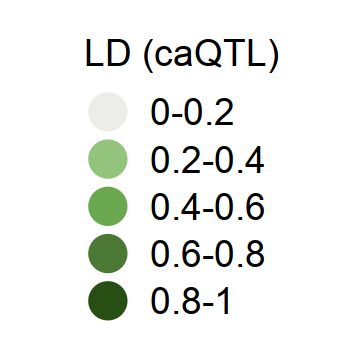

In [133]:
a = qtldata3 %>%
    filter(element_id %like% "atac") %>%
    mutate(LD_group = factor(LD_group, levels = groups))

legend1 = ggplot(a, aes(x = pos/1e6, y = -log10(pval), color = LD_group)) + geom_point() + jn_classic  +
    facet_wrap(.~element_id, ncol = 3)  + 
    theme(
        legend.text = element_text(size = 22),
        legend.title = element_text(size = 22)
    ) +
    scale_color_manual(values = color_gradients$caqtl, labels = c("0-0.2", "0.2-0.4", "0.4-0.6", "0.6-0.8", "0.8-1"), name = "LD (caQTL)") + 
    guides(color = guide_legend(override.aes = list(size = 10)))

psize(w = 3, h = 3)
grid.draw(cowplot::get_legend(legend1))

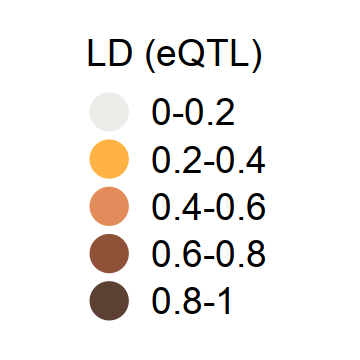

In [134]:
a = qtldata3 %>%
    filter(element_id %like% "ENSG") %>%
    mutate(LD_group = factor(LD_group, levels = groups))

legend2 = ggplot(a, aes(x = pos/1e6, y = -log10(pval), color = LD_group)) + geom_point() + jn_classic  +
    facet_wrap(.~element_id, ncol = 3)  + 
    theme(
        legend.text = element_text(size = 22),
        legend.title = element_text(size = 22)
    ) + 
    scale_color_manual(values = color_gradients$eqtl, labels = c("0-0.2", "0.2-0.4", "0.4-0.6", "0.6-0.8", "0.8-1"), name = "LD (eQTL)") + 
    guides(color = guide_legend(override.aes = list(size = 10)))

psize(w = 3, h = 3)
grid.draw(cowplot::get_legend(legend2))

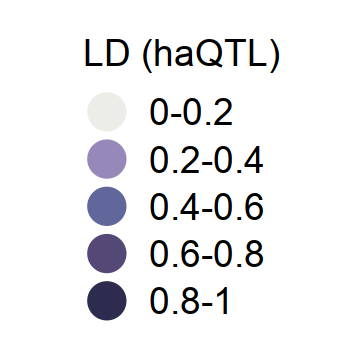

In [135]:
a = qtldata3 %>%
    filter(element_id %like% "atac") %>%
    mutate(LD_group = factor(LD_group, levels = groups))

legend3 = ggplot(a, aes(x = pos/1e6, y = -log10(pval), color = LD_group)) + geom_point() + jn_classic  +
    facet_wrap(.~element_id, ncol = 3)  + 
    theme(
        legend.text = element_text(size = 22),
        legend.title = element_text(size = 22)
    ) +
    scale_color_manual(values = color_gradients$haqtl, labels = c("0-0.2", "0.2-0.4", "0.4-0.6", "0.6-0.8", "0.8-1"), name = "LD (haQTL)") + 
    guides(color = guide_legend(override.aes = list(size = 10)))

psize(w = 3, h = 3)
grid.draw(cowplot::get_legend(legend3))

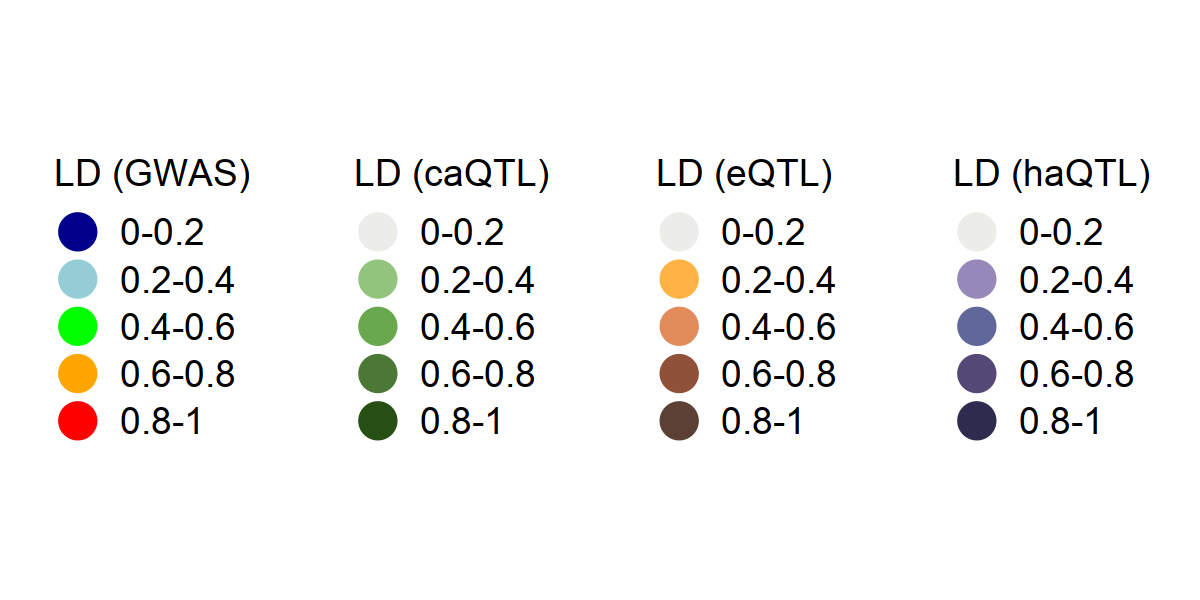

In [136]:
psize(w = 10, h = 5)
plot_grid(get_legend(legend0), get_legend(legend1), get_legend(legend2), get_legend(legend3), nrow = 1)